# Redes neuronales junto con NeuralODEs

Vamos a mezclar los ejemplos vistos anteriormente, para ello vamos a crear una red neuronal la cual también pase por una NeuralODE, en este caso prefiero poner una aumentada y así evitar el problema anterior. La teoria de estas ya las vimos antes

In [212]:
using Flux
using DifferentialEquations
using DiffEqFlux
using Plots
using Flux: train!
using Distributions
using DiffEqFlux, DifferentialEquations
using Statistics, LinearAlgebra, Plots
using Flux.Data: DataLoader, Flux
using Optimization, OptimizationOptimJL
using OptimizationFlux, Random

Comenzamos como simpre generando los dastos que vamos a utilizar

In [213]:
function Noise_Sine(x)
    return sin(2π*x) + rand(Normal(0,0.05))
end;

In [236]:
t_train = Float32.(hcat(0:0.01:2...))
y_train = Float32.(Noise_Sine.(t_train))
y_test = Float32.(Noise_Sine.(t_train))
trange = t_train[1,:]
tspan = (t_train[1], t_train[end])
t_train

1×201 Matrix{Float32}:
 0.0  0.01  0.02  0.03  0.04  0.05  …  1.95  1.96  1.97  1.98  1.99  2.0

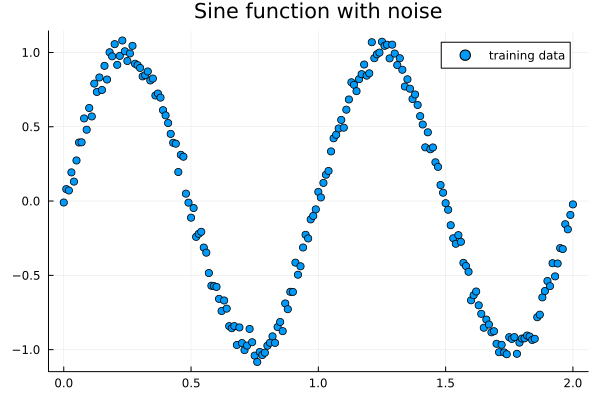

In [215]:
scatter(t_train[1,:], y_train[1,:], label="training data", title="Sine function with noise")

In [216]:
dudt = Chain(Dense(21 => 30, celu),
            Dense(30 => 30, relu),
            Dense(30 => 25, relu),
            Dense(25 => 21, tanh_fast)) # Creamos el modelo que va a ser nuestra función diferenciada

Chain(
  Dense(21 => 30, celu),                # 660 parameters
  Dense(30 => 30, relu),                # 930 parameters
  Dense(30 => 25, relu),                # 775 parameters
  Dense(25 => 21, tanh_fast),           # 546 parameters
)                   # Total: 8 arrays, 2_911 parameters, 11.871 KiB.

A esta NN la vamos a hacer pasar por una NerualODE y extraemos los paráemtros de este modelo

In [267]:
diffeqarray_to_array(x) = reshape(x, size(x)[1:2]) # Esto acomoda la solución de la EDO en un arreglo de 2 dimensiones 21 x length(trange)

n_ode = NeuralODE(dudt, tspan, Tsit5(), save_everystep = false,
reltol = 1e-3, abstol = 1e-3, save_start = false)
n_ode = AugmentedNDELayer(n_ode, 20)
ps = n_ode.p
model = Chain((x, p = n_ode.p) -> n_ode(x, p), # En primer lugar manda el input a la red neuronal y luego los parámetros
                Array,  # Lo que devuelve la NODE es la solución desde t0 a t1 y devuelve f en cada paso de tiempo
                diffeqarray_to_array, # Esto solo deja la matriz 21x201
                Dense(21, 1)) # Esta f pasa por una capa densa para que la salida sea un número

Chain(
  var"#195#196"(),
  Array,
  diffeqarray_to_array,
  Dense(21 => 1),                       # 22 parameters
) 

Creamos la función costo para esta red neruronal, igual que antes usamos mse

In [2]:
data = Flux.dataloader(t_train, y_train, batchsize = 20, shuffle = true)
loss_node(x, y) = mean((model(x) .- y) .^ 2)

UndefVarError: UndefVarError: `Flux` not defined

In [186]:
accuraccy_train = []
accuraccy_test = []
loss_train = []
loss_test = []

Any[]

In [187]:
accuracy_train = []
accuracy_test = []
function accuracy(y)
    num_correct = 0
    predictions = model(t_train)
    for i in 1:length(predictions)
        if abs(predictions[1,i] - y[1,i]) < 0.1
            num_correct += 1
        end
    end
    return (num_correct/length(predictions)) * 100.0
end

accuracy (generic function with 1 method)

Seteamos la cantidad de épocas a entrenar, el ratio de aprendizaje y el modelo de optimización que vamos a utilizar. Además creamos la función callback para obtener información de cada época de entrenamiento

In [188]:
opt = ADAM(0.005)
iter = 0
cb = function()
    global iter
    iter += 1
    if iter % length(data) == 0
        actual_loss = loss_node(data.data[1], data.data[2])
        println("Iteration $iter || Loss = $actual_loss")
        push!(loss_train, actual_loss)
        push!(loss_test, loss_node(data.data[1], y_test))
        push!(accuracy_train, accuracy(y_train))
        push!(accuracy_test, accuracy(y_test))
    end
end

for _ in 1:150
    Flux.train!(loss_node, Flux.params(ps, model), data, opt, cb = cb)
end

Iteration 11 || Loss = 0.4200052


Iteration 22 || Loss = 0.41301036


Iteration 33 || Loss = 0.36416912


Iteration 44 || Loss = 0.3662309


Iteration 55 || Loss = 0.35669947


Iteration 66 || Loss = 0.36738726


Iteration 77 || Loss = 0.36924744


Iteration 88 || Loss = 0.36130562


Iteration 99 || Loss = 0.35814345


Iteration 110 || Loss = 0.35927


Iteration 121 || Loss = 0.34049374


Iteration 132 || Loss = 0.33538753
Iteration 143 || Loss = 0.31694785


Iteration 154 || Loss = 0.3018202


Iteration 165 || Loss = 0.2738763


Iteration 176 || Loss = 0.28933448


Iteration 187 || Loss = 0.30058596
Iteration 198 || Loss = 0.18402877


Iteration 209 || Loss = 0.29460987

Iteration 220 || Loss = 0.13901211
Iteration 231 || Loss = 0.1842881


Iteration 242 || Loss = 0.14878869


Iteration 253 || Loss = 0.11119905


Iteration 264 || Loss = 0.07884019


Iteration 275 || Loss = 0.10990584


Iteration 286 || Loss = 0.049398884


Iteration 297 || Loss = 0.04746902


Iteration 308 || Loss = 0.06419098


Iteration 319 || Loss = 0.032241542


Iteration 330 || Loss = 0.024053913


Iteration 341 || Loss = 0.023901954


Iteration 352 || Loss = 0.018620089


Iteration 363 || Loss = 0.015024598


Iteration 374 || Loss = 0.014448637


Iteration 385 || Loss = 0.02427736


Iteration 396 || Loss = 0.020799516


Iteration 407 || Loss = 0.030990947


Iteration 418 || Loss = 0.014303047


Iteration 429 || Loss = 0.026052738


Iteration 440 || Loss = 0.057731356


Iteration 451 || Loss = 0.053535685


Iteration 462 || Loss = 0.015113207


Iteration 473 || Loss = 0.0135196205


Iteration 484 || Loss = 0.024517776

Iteration 495 || Loss = 0.10003405
Iteration 506 || Loss = 0.113504805


Iteration 517 || Loss = 0.06078607


Iteration 528 || Loss = 0.207593


Iteration 539 || Loss = 0.037563454


Iteration 550 || Loss = 0.025035366


Iteration 561 || Loss = 0.02047339


Iteration 572 || Loss = 0.020600053


Iteration 583 || Loss = 0.03259518

Iteration 594 || Loss = 0.026480295
Iteration 605 || Loss = 0.012453509


Iteration 616 || Loss = 0.0059783827


Iteration 627 || Loss = 0.0059117014


Iteration 638 || Loss = 0.04065108


Iteration 649 || Loss = 0.013930589


Iteration 660 || Loss = 0.034625676


Iteration 671 || Loss = 0.048560146


Iteration 682 || Loss = 0.023416363
Iteration 693 || Loss = 0.026955571


Iteration 704 || Loss = 0.0099779125


Iteration 715 || Loss = 0.0082322415


Iteration 726 || Loss = 0.018351117


Iteration 737 || Loss = 0.004497331


Iteration 748 || Loss = 0.007589214


Iteration 759 || Loss = 0.02477149


Iteration 770 || Loss = 0.03514851


Iteration 781 || Loss = 0.023009589


Iteration 792 || Loss = 0.0107878605


Iteration 803 || Loss = 0.013928243


Iteration 814 || Loss = 0.00785533


Iteration 825 || Loss = 0.0046612383


Iteration 836 || Loss = 0.004396022


Iteration 847 || Loss = 0.009754897


Iteration 858 || Loss = 0.0077353367


Iteration 869 || Loss = 0.0070434543


Iteration 880 || Loss = 0.008004825


Iteration 891 || Loss = 0.005561572


Iteration 902 || Loss = 0.018008009


Iteration 913 || Loss = 0.03132437


Iteration 924 || Loss = 0.088328876


Iteration 935 || Loss = 0.026866656


Iteration 946 || Loss = 0.016381579


Iteration 957 || Loss = 0.014180397


Iteration 968 || Loss = 0.043775078


Iteration 979 || Loss = 0.02231428


Iteration 990 || Loss = 0.043339174


Iteration 1001 || Loss = 0.10351269


Iteration 1012 || Loss = 0.052093875


Iteration 1023 || Loss = 0.048967045


Iteration 1034 || Loss = 0.030075725


Iteration 1045 || Loss = 0.025069391


Iteration 1056 || Loss = 0.055826586


Iteration 1067 || Loss = 0.03444232


Iteration 1078 || Loss = 0.026857516


Iteration 1089 || Loss = 0.013916813


Iteration 1100 || Loss = 0.018636936


Iteration 1111 || Loss = 0.015333756


Iteration 1122 || Loss = 0.007349694


Iteration 1133 || Loss = 0.0058971182


Iteration 1144 || Loss = 0.0038278901


Iteration 1155 || Loss = 0.006135225


Iteration 1166 || Loss = 0.009642129


Iteration 1177 || Loss = 0.0049869474


Iteration 1188 || Loss = 0.0065561426


Iteration 1199 || Loss = 0.0044575976


Iteration 1210 || Loss = 0.011631051


Iteration 1221 || Loss = 0.014832262


Iteration 1232 || Loss = 0.0043277177


Iteration 1243 || Loss = 0.0074076615
Iteration 1254 || Loss = 0.010990828


Iteration 1265 || Loss = 0.010725719


Iteration 1276 || Loss = 0.011047572


Iteration 1287 || Loss = 0.025393037


Iteration 1298 || Loss = 0.06822658


Iteration 1309 || Loss = 0.023282725


Iteration 1320 || Loss = 0.027668511


Iteration 1331 || Loss = 0.018896706


Iteration 1342 || Loss = 0.019325068


Iteration 1353 || Loss = 0.031961713


Iteration 1364 || Loss = 0.010893276


Iteration 1375 || Loss = 0.013137765


Iteration 1386 || Loss = 0.004314589


Iteration 1397 || Loss = 0.014736307


Iteration 1408 || Loss = 0.0070901266


Iteration 1419 || Loss = 0.003871342


Iteration 1430 || Loss = 0.0066825664


Iteration 1441 || Loss = 0.003317422


Iteration 1452 || Loss = 0.0074139833


Iteration 1463 || Loss = 0.0062599876


Iteration 1474 || Loss = 0.009756688


Iteration 1485 || Loss = 0.014315973


Iteration 1496 || Loss = 0.009469981


Iteration 1507 || Loss = 0.012465798


Iteration 1518 || Loss = 0.012306503


Iteration 1529 || Loss = 0.012656546


Iteration 1540 || Loss = 0.012210481


Iteration 1551 || Loss = 0.005948917


Iteration 1562 || Loss = 0.013772268
Iteration 1573 || Loss = 0.0073364


Iteration 1584 || Loss = 0.0054842234


Iteration 1595 || Loss = 0.007599129


Iteration 1606 || Loss = 0.008396512


Iteration 1617 || Loss = 0.0061867186


Iteration 1628 || Loss = 0.0072108964


Iteration 1639 || Loss = 0.009246091


Iteration 1650 || Loss = 0.010650545


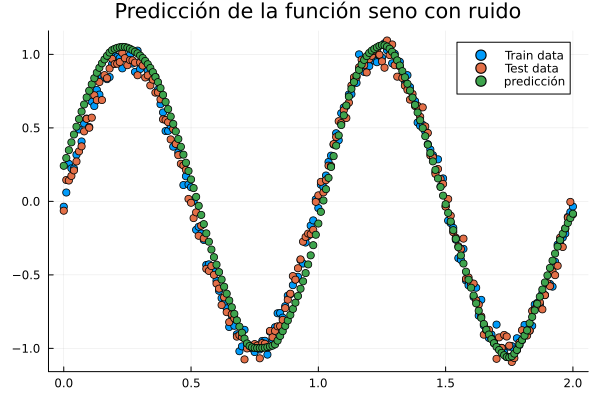

In [189]:
scatter(t_train[1,:],y_train[1,:], label="Train data", title="Predicción de la función seno con ruido")
scatter!(t_train[1,:],y_test[1,:], label="Test data")
scatter!(t_train[1,:],model(t_train)[1,:],label = "predicción")

Ahora veamos el Loss en función de las épocas de entrenamiento

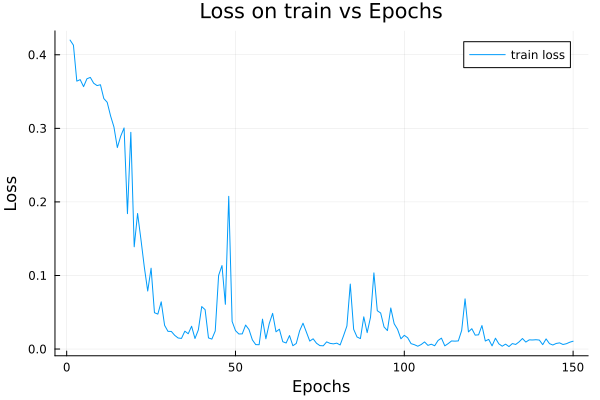

In [190]:
plot(loss_train, label="train loss",xlabel = "Epochs", ylabel = "Loss", title = "Loss on train vs Epochs")

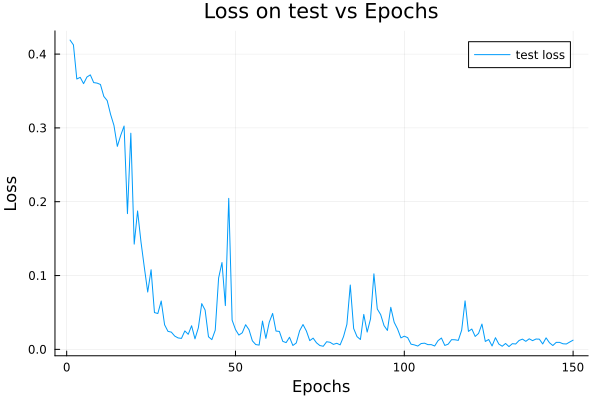

In [191]:
plot(loss_test, label="test loss",xlabel = "Epochs", ylabel = "Loss", title = "Loss on test vs Epochs")

Maximum accuracy on train: 93.03482587064677%


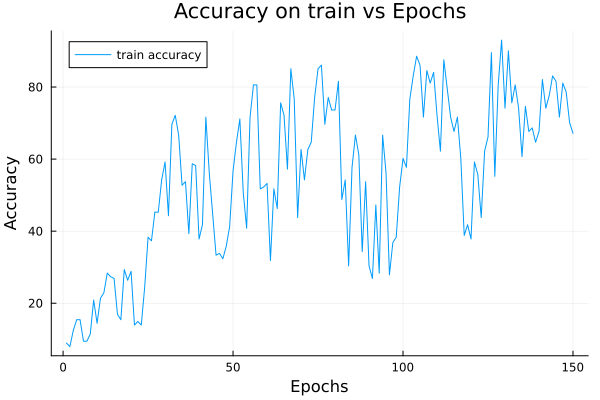

In [192]:
println("Maximum accuracy on train: ", maximum(accuracy_train), "%")
plot(accuracy_train, label="train accuracy",xlabel = "Epochs", ylabel = "Accuracy", title = "Accuracy on train vs Epochs")

Maximum accuracy on test: 90.54726368159204%


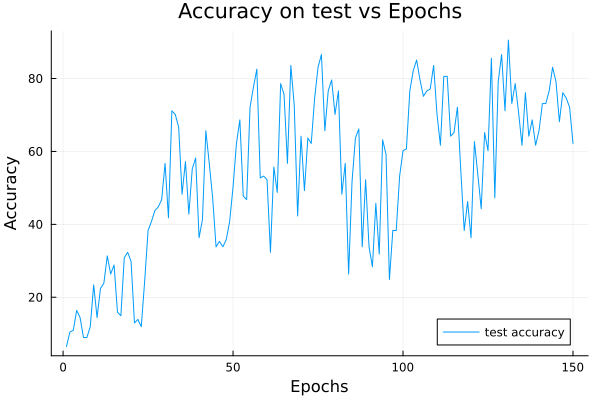

In [193]:
println("Maximum accuracy on test: ", maximum(accuracy_test), "%")
plot(accuracy_test, label = "test accuracy",xlabel = "Epochs", ylabel = "Accuracy", title = "Accuracy on test vs Epochs")